# Desafío NeuralWorks: probabilidad de demora de vuelo.

Este notebook contiene el entrenamiento y dump de un modelo de machine learning para la predicción de la probabilidad de que un vuelo se demore. Todos los requerimientos se instalan al instalar con poetry el proyecto entero:

```bash
poetry install
```

Ese comando instalará todas las dependencias y creará el paquete `challenge_neueralworks` (es un typo de la creación del repo que dejé) que se utiliza en este notebook.

**Disclaimer:** Se crea este notebook porque el entregado para el desafío no corría desde la primera a la última celda y sospecho que teníamos versiones de python y otras librerías muy distintas por los errores que arrojaba. De todas formas, hay algunas funciones o decisiones tomadas por Juan que se toman en cuenta en este notebook.

## Índice:
1. Carga de datos.
2. Variable Objetivo.
3. Preprocesamiento: Transformación de algunas columnas.
4. Entrenamiento:
    1. Regresión Logística.
    2. SVM con upsampling de la clase minoritaria.
5. Dump del modelo.

## Carga de los datos:

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [41]:
df = pd.read_csv('../data/dataset_SCL.csv')

/var/folders/f4/t3qrdnv557x8tnk3zxr6vr3w0000gn/T/ipykernel_5873/3157898594.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/dataset_SCL.csv')


In [42]:
df.sample(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
59244,2017-11-25 07:34:00,259,SCEL,SCTE,LAN,2017-11-25 07:34:00,259,SCEL,SCTE,LXP,25,11,2017,Sabado,N,Grupo LATAM,Santiago,Puerto Montt
44955,2017-09-01 14:50:00,8519,SCEL,SBGR,ONE,2017-09-01 14:50:00,8519,SCEL,SBGR,ONE,1,9,2017,Viernes,I,Oceanair Linhas Aereas,Santiago,Sao Paulo
26225,2017-05-14 11:25:00,434,SCEL,SAME,LAN,2017-05-14 11:44:00,434,SCEL,SAME,LAN,14,5,2017,Domingo,I,Grupo LATAM,Santiago,Mendoza


## Generación de variable objetivo:

Se generará una variable objetivo para pruebas y ver como afectan algunas variables el atraso o no en los vuelos. Esto será para el análisis exploratorio y el entrenamiento. 

La variable se construirá así:
$$ x = fecha_{operacion} - fecha_{programada}$$
Tomando en cuenta $x$ en minutos, se construirá la siguiente variable del tipo binaria:
$$ y = \begin{cases}
1 & \text{ if } x>= \lambda [min] \\
0 & \text{ if } x< \lambda [min]
\end{cases} $$

Donde $\lambda$ corresponde a un $threshold$ definido por el usuario. En este caso se utilizará 15 [min] tomando en cuenta el trabajo realizado por Juan.

Adicionalmente, se tomarán en cuenta las variables creadas en el notebook `to-expose.ipynb` y/o se crearán algunas variables adicionales.

In [43]:
def get_target(data, threshold=15):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return 1 if dif_min >= threshold else 0

In [44]:
df['target'] = df.apply(get_target, axis=1)

In [45]:
df.sample(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,target
31017,2017-06-02 20:25:00,354,SCEL,SCCF,LAN,2017-06-02 20:14:00,354,SCEL,SCCF,LXP,2,6,2017,Viernes,N,Grupo LATAM,Santiago,Calama,0
24443,2017-05-30 06:40:00,120,SCEL,SCFA,LAN,2017-05-30 07:07:00,120,SCEL,SCFA,LAN,30,5,2017,Martes,N,Grupo LATAM,Santiago,Antofagasta,1
58726,2017-11-28 06:31:00,162,SCEL,SCDA,LAN,2017-11-28 06:39:00,162,SCEL,SCDA,LAN,28,11,2017,Martes,N,Grupo LATAM,Santiago,Iquique,0


In [46]:
def calcular_tasa(df, columna):
    
    dic_atrasos = {}
    for _, row in df.iterrows():
        if row['target'] == 1:
            if row[columna] not in dic_atrasos:
                dic_atrasos[row[columna]] = 1
            else:
                dic_atrasos[row[columna]] += 1
    
    total_values = df[columna].value_counts()
    
    dic_tasas = {}
    for name, total in total_values.iteritems():
        if name in dic_atrasos:
            dic_tasas[name] = round(total / dic_atrasos[name], 2)
        else:
            dic_tasas[name] = 0
            
    return pd.DataFrame.from_dict(data = dic_tasas, orient = 'index', columns = ['Tasa (%)'])

In [47]:
tasas_destinos = calcular_tasa(df, 'SIGLADES')
tasas_destinos

/var/folders/f4/t3qrdnv557x8tnk3zxr6vr3w0000gn/T/ipykernel_5873/4072666734.py:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, total in total_values.iteritems():


,Tasa (%)
Buenos Aires,3.63
Antofagasta,6.36
Lima,4.04
Calama,7.57
Puerto Montt,5.45
...,...
Quito,1.00
Washington,0.00
"Pisco, Peru",0.00
Puerto Stanley,1.00


In [48]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['DIA-I'] = df['Fecha-I'].dt.day
df['MES-I'] = df['Fecha-I'].dt.month
df['HORA-I'] = df['Fecha-I'].dt.hour

In [49]:
df.sample(3)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,target,DIA-I,MES-I,HORA-I
52711,2017-10-03 21:30:00,172,SCEL,SCDA,LAN,2017-10-03 21:47:00,172,SCEL,SCDA,LAN,...,2017,Martes,N,Grupo LATAM,Santiago,Iquique,1,3,10,21
47444,2017-09-26 08:00:00,257,SCEL,SCTE,LAN,2017-09-26 08:07:00,257,SCEL,SCTE,LXP,...,2017,Martes,N,Grupo LATAM,Santiago,Puerto Montt,0,26,9,8
23734,2017-05-22 13:00:00,122,SCEL,SCCF,SKU,2017-05-22 12:59:00,122,SCEL,SCCF,SKU,...,2017,Lunes,N,Sky Airline,Santiago,Calama,0,22,5,13


## Transformación de algunas columnas:

Las columnas correspondientes a fechas/marcas temporales se codificarán con una transformada Seno-Coseno para representar de mejor forma el ciclo en estas. Es decir, que las 23.59 están mas cerca de las 00.00 que de las 23.50. Esto puede ayudar a entender mejor algunas componentes temporales y mejorar predicciones.

Adicionalmente, se le aplica `OneHotEncoder` a las variables categóricas `['OPERA', 'TIPOVUELO']`.

La selección de características viene heredada del notebook de Juan.

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from challenge_neueralworks.src.models.delay.preprocesing import CyclicalEncoder

In [51]:
date_cols = ['DIA-I', 'MES-I', 'HORA-I']
categorical_cols = ['OPERA', 'TIPOVUELO']

In [52]:
featurisation = ColumnTransformer(transformers=[
    ('cyclic', CyclicalEncoder(date_cols), date_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])


## Entrenamiento
### Modelo regresión logística:

Se entrenará este modelo por la "simpleza". La idea es ir rápido para tener una versión 0 de esto funcionando.

In [54]:
# columnas a usar
columns = ['DIA-I', 'MES-I', 'HORA-I', 'OPERA', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'target']

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [56]:
log_reg = LogisticRegression()

In [57]:
pipeline = Pipeline(
    [
        ('features', featurisation),
        ('learner', log_reg)
    ]
)

In [58]:
# train-test split
train_data, test_data = train_test_split(
    shuffle(df[columns]),
    random_state=0,
    test_size = 0.33
)

# model training
model = pipeline.fit(
    train_data[filter(lambda x: x != 'target', columns)],
    train_data['target']
)

/Users/diegoirarrazabal/.pyenv/versions/3.10.4/envs/challenge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
train_data[filter(lambda x: x != 'target', columns)]

,DIA-I,MES-I,HORA-I,OPERA,TIPOVUELO,SIGLADES,DIANOM
5331,18,1,19,Grupo LATAM,I,Madrid,Miercoles
45970,11,9,18,Sky Airline,N,Antofagasta,Lunes
268,15,1,16,Aerolineas Argentinas,I,Buenos Aires,Domingo
53217,10,10,7,Grupo LATAM,N,Balmaceda,Martes
12084,19,3,12,Alitalia,I,Roma,Domingo
...,...,...,...,...,...,...,...
24346,31,5,14,Grupo LATAM,N,Castro (Chiloe),Miercoles
31314,23,6,17,Grupo LATAM,I,Buenos Aires,Viernes
66841,30,12,1,Grupo LATAM,I,Bogota,Sabado
36053,24,7,16,Grupo LATAM,N,Puerto Montt,Lunes


In [60]:
y_pred = model.predict(test_data)

print(
    "Classification Report: \n",
    classification_report(test_data['target'], y_pred)
 )

print(
    "Confusion Matrix: \n",
    confusion_matrix(test_data['target'], y_pred)
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     18019
           1       0.64      0.03      0.05      4489

    accuracy                           0.80     22508
   macro avg       0.72      0.51      0.47     22508
weighted avg       0.77      0.80      0.72     22508

Confusion Matrix: 
 [[17946    73]
 [ 4360   129]]


### Upsampling y otro SVM:

In [61]:
#Resample
from sklearn.utils import resample
from sklearn.svm import SVC

data_no_atraso = df[df['target'] == 0]
data_atraso = df[df['target'] == 1]

data_atraso_upsampled = resample(
    data_atraso, 
    replace = True,     # sample with replacement
    n_samples = 30000,    # to match majority class
    random_state = 42
) # reproducible results

data_upsampled = pd.concat([data_no_atraso, data_atraso_upsampled])

In [62]:
svc = SVC(gamma='auto')
pipeline_svc = Pipeline(
    [
        ('features', featurisation),
        ('learner', svc)
    ]
)

In [63]:
# train-test split
upsampled_train_data, upsampled_test_data = train_test_split(
    shuffle(data_upsampled[columns]),
    random_state=0,
    test_size = 0.33
)

# model training
model_svc = pipeline_svc.fit(
    upsampled_train_data[filter(lambda x: x != 'target', columns)],
    upsampled_train_data['target']
)

In [64]:
y_pred = model_svc.predict(upsampled_test_data)

print(
    "Classification Report: \n",
    classification_report(upsampled_test_data['target'], y_pred)
 )

print(
    "Confusion Matrix: \n",
    confusion_matrix(upsampled_test_data['target'], y_pred)
)

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.97      0.79     18058
           1       0.66      0.11      0.19      9857

    accuracy                           0.67     27915
   macro avg       0.66      0.54      0.49     27915
weighted avg       0.66      0.67      0.58     27915

Confusion Matrix: 
 [[17483   575]
 [ 8741  1116]]


## Comparación y análisis de resultados:

In [65]:
classifiers = {
    "LinearRegression": model,
    "SVM": model_svc
}

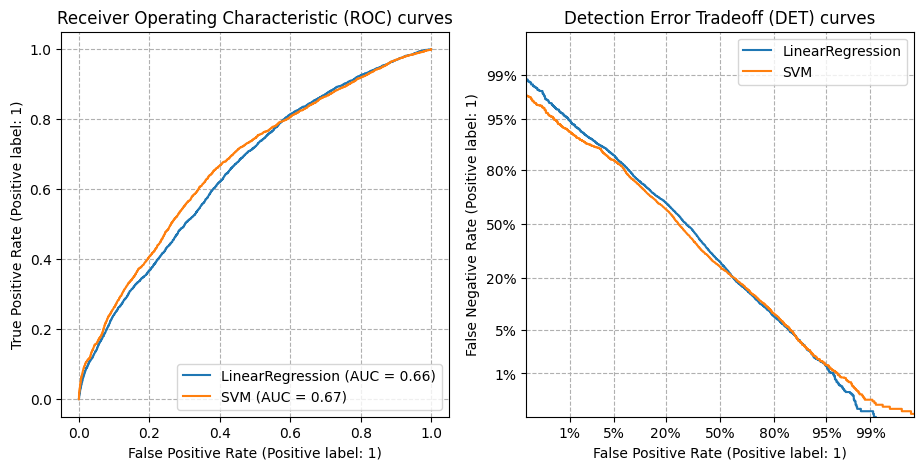

In [66]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

X_test = test_data[filter(lambda x: x != 'target', columns)]
y_test = test_data['target']

for name, clf in classifiers.items():

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

Tomando en cuenta las curvas operacionales, es dificil tomar una decisión de modelos sólo basado en esto. Ambas performance son similares.

Se cargará la regresión lineal, dado que obtiene mejor accuracy en general. Aun dado que SVC predice mejor para los atrasos, da muchos falsos positivos.

## Dump del modelo

Se utiliza `dill` porque funcionó mejor para empaquetar la clase creada `CyclicalEncoder`. Se probó con `joblib` y `pickle`

In [67]:
import dill as pickle

In [68]:
model.steps

[('features',
  ColumnTransformer(transformers=[('cyclic',
                                   CyclicalEncoder(column_names=['DIA-I', 'MES-I',
                                                                 'HORA-I']),
                                   ['DIA-I', 'MES-I', 'HORA-I']),
                                  ('cat', OneHotEncoder(),
                                   ['OPERA', 'TIPOVUELO'])])),
 ('learner', LogisticRegression())]

In [27]:
# pickle.dump(
#     model,
#     open('../models/delay/model_v0.pkl', 'wb'),
#     byref=False
# )